# Final Baseline Submission: Toxic Language Classification 
**w207 Spring 2018 - Final Project Baseline**

**Team: Paul, Walt, Yisang, Joe**



## Project Description 

Our challenge is to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate.  The toxic language data set is sourced from Wikipedia and available as a public kaggle data set. 



## Objective

Our goal is to use various machine learning techniques used in class to develop high quality ML models and pipelines.  

Our research deliverables will be the following:

Exercise and build upon concepts covered in class and test out the following supervised models:
1. Regression (LASSO, Logistic)
2. Naive Bayes
3. Trees (XGBoost)
4. Neural Networks MPI
5. KNN
6. Derive an ETL framework to ensure some standard across different model performances


## Assumptions and Defining the Modeling Problem

It is extremely important to clarify whether this is a **multi-label or multi-class problem**. 

Given the target labels for this challenge, text observation can be any multiple labels (toxic, severe toxic, threat, insult, etc) at the same time or none at all and is there for a multi-label problem.  

The reason for this assumption is to avoid any data leakage that would affect the intended prediction.  

Our team is interested in exploring machine learning solutions for classifying every target class in toxic language.  Therefore, multi-class or aggregating the target labels into one label would only predict whether or not a text observation is toxic or not.  While this is also an interesting problem, due to the time constraints, our team will be focused on being able to provide predictions for each target class and therefore will use multi-modeling approaches later on in this case study.  

Our team will not submit out final prediction to the kaggle leaderboard.  Instead, **our team will create a new 70/30 train/test split that all models will be required to use for training and testing**.  Different notebooks may create internal dev sets, however, the ultimate AUC score is determined by the established test set. 

## Establishing Metrics

The **primary metric to evaluate multiple modeling approaches will be the ROC derived AUC Score**. 
The Toxic Language Kaggle Competition uses AUC as leaderboard metric
Useful metric for evaluating model performance based on the TPR over the FPR. 
Our team will also evaluate two other secondary metrics to supplement our analysis. 

AUC is a good metric but is not perfect.  

From an AUC score it is difficult to see how well the model deals with False Positive predictions.  While it does a better job than accuracy when conveying performance for imbalanced targets, we will consider some additional metrics to gain insight when False Positives and False Negatives come into account. 

**Secondary Metric: Precision**
- (TP)/(TP+FP)
- Tells us the proportion of text predicted as some kind of toxic label is actually toxic.

**Seconday Metric: Recall** 
- (TP)/(TP+FN)
- Tells us the proportion of text that were actually toxic had been correctly predicted.


## Machine Learning Approach Overview


The following diagram the general process and global pipeline that we are building for this problem

**The major steps:**

1. Create new train and test data since Kaggle Private Board will not be used to assess the origin test set.
2. Apply our team's finalizes text processing along with the chosen TF-IDF vectorizor.  
    a. TFIDF will be the main vectorizer across all models to ensure a more apple's to apples comparison. 
3. Preprocessing data will be piped to the rest of the different modeling notebooks. 
4. Predictions are saved to a data folder shared in the repo 
5. Predictions are read back into the main notebook for final evaluation. 
6. Top 3 Models are Evaluated and Concluded

<img src="img/process.png" width="500">

### Python Environment Setup

The following cell contains the imports used for this project, it's recommended to make sure all packages build properly before proceeding.  

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
import string

from IPython.display import display, HTML

from subprocess import check_output

#sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import auc, roc_curve
from sklearn import metrics



#xgboost
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)


#scipy imports
from scipy.sparse import hstack

#Visualization imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
#import matplotlib as mp
import seaborn as sns

import matplotlib.gridspec as gridspec 

#NLTK imports
import string

import nltk
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk.tokenize import punkt as punkt
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
stop = stopwords.words('english')

# These imports enable the use of NLTKPreprocessor in an sklearn Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

#scipy imports
from scipy.sparse import hstack

#General imports
import pprint
import time
from collections import Counter

#pickle
import pickle

sns.set(style="white", context="talk")
np.random.seed(455)

# Establishing the target classes
target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

C:\Users\Joseph Lee\AppData\Local\conda\conda\envs\mids\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Joseph Lee\AppData\Local\conda\conda\envs\mids\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Data Ingestion


The cell below contains the code that was used to process the data.  The commented out code are the steps used to create the new standardized training and testing sets which are saved and re-read from the team data folder.

In [2]:
####################################################
# Data Setup
####################################################
# read frames localy through csv
#train_df = pd.read_csv("../w207_FinalProject/data/train.csv")
#test_df = pd.read_csv("../w207_FinalProject/data/test.csv")

# Random index generator for splitting training data
# Note: Each rerun of cell will create new splits.
#randIndexCut = np.random.rand(len(train_df)) < 0.7

# split new frame to distribute across notebooks
#new_test_split = test_df[~randIndexCut].to_csv("../w207_FinalProject/data/new_test.csv")
#new_train_split = train_df[randIndexCut].to_csv("../w207_FinalProject/data/new_train.csv")

# read in new train and test from data folder
new_train_df = pd.read_csv("../w207_FinalProject/data/new_train.csv")
new_test_df = pd.read_csv("../w207_FinalProject/data/new_test.csv")

#Split up data
test_data = new_test_df["comment_text"]
test_data, test_labels = new_test_df["comment_text"], new_test_df[target_names]
train_data, train_labels = new_train_df["comment_text"], new_train_df[target_names]

print 'total training observations:', new_train_df.shape[0]
print 'training data shape:', train_data.shape
print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'labels names:', target_names

total training observations: 111828
training data shape: (111828L,)
training label shape: (111828, 6)
test label shape: (47743, 6)
labels names: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


### Exploratory Data Analysis

### Assessing the Targets

Let's see how imblanced the label set is in order to have a better understanding with the label quality of the given data set. 

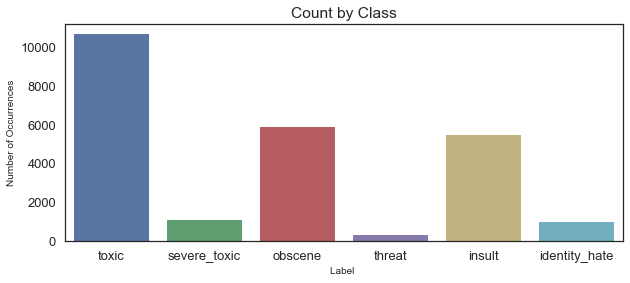

In [11]:
def simpleClassBar(labels):
    """Function for creating a simple class bar plot
    
    This function requires document data long with the labels and label_names.  

    Args:
        labels: label data frame 
    Returns:
         barplot
        
    """
    target_counts = labels.apply(np.sum,0)
    #Plot counts by class in barplot
    plt.figure(figsize=(10,4))
    ax= sns.barplot(target_counts.index, target_counts.values)
    #format plot
    plt.title("Count by Class")
    plt.ylabel('Number of Occurrences', fontsize=10)
    plt.xlabel('Label ', fontsize=10)
    #return plt 
    return(plt.show())

simpleClassBar(labels = train_labels)

The data is fairly imbalanced when counting label occurrences. 

**Major Takeaway**

Due to the strong imbalanced nature of this, we will explore and explore options to help mitigate class imbalance.  
Downsampling could be drastic since the difference in counts between the majority class and minority class.  Each model has various ways of addressing issues with sampling and each team will explore wayus to mitigate this through sampling methods and exploring parameters that can help mitigate the imbalance (e.g. cross validation, regularization, sampling methods).  It would be ideal to expand the training set and add more observations for the minority classes since upsampling could overduplicate certain observations as well.  

However, due to the time constraint, the one step that the team concluded was the use of AUC, Precision, and Recall since they are optimal metrics for imbalanced data sets.  Please refer to metrics section above. 

### Categorical Analysis

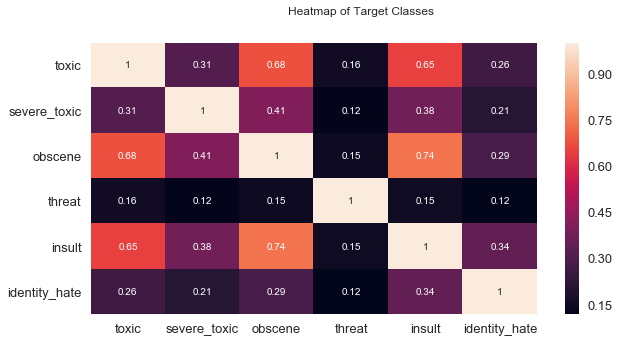

In [12]:
# heatmap function
def createLabelHeatMap(labels):
    """Function for creating a simple class bar plot
    
    This function requires document data long with the labels and label_names.  

    Args:
        labels: data frame containing multi-label data 
    Returns:
         seaborn object
        
    """
    f, ax_heatmap = plt.subplots(figsize=(10, 5))
    f.suptitle('Heatmap of Target Classes')
    # use the corr mat of labels to generate heatmap
    return(sns.heatmap(labels.corr(), annot=True, ax=ax_heatmap))

createLabelHeatMap(labels = train_labels)

### Venn Diagram

Venn diagrams are a useful method for comparing multiple categorical events across each other.

Venn diagrams are optimal for 3 set analysis so we used the heatmap to narrow down to four signals that show interesting correlation. 

- toxic
- severe_toxic
- insult
- obscene

All four of these targets have noticeable correlation.  

** 4-Way Approx**
<img src="img/4_approx.png" width="500">
** 3- Way Approx Combination 1**
<img src="img/3_approx_1.png" width="500">
**3- Way Approx Combination 2**
<img src="img/3_approx_2.png" width="500">




We can see some interesting observations:

- `severe_toxic` is subset feature and only intersects with other classes as shown in the venn diagrams.
- Every `severe_toxic` label is a subset of `toxic`
- `obscene` and `insult` seem to possess both labels that are toxic and seperate from toxic.  This emphasizes the nuance of linguistics and language since it's possible to be insulting while not using toxic language.  This can also foreshadow a difficult part of NLP which is dealing with context and tones such as sarcasm. 
- The major takeaway is that these classes are both imbalanced and exhibit highly correlative patterns. 
    - We can no longer assume that classes add up to 1.00 Probability or that each target is mutually exclusive from one another and is thus a multi-label problem.
    - This affects the way we have to design the Machine Learning pipeline.
    - Each machine learning pipeline will have to create at minimum 6- models for each target class in order to provide predictions for each target class.  
    - While it may seem tempting to creat a super label by joining all the labels together, this would distort the original problem since such a label will be useful for predicting whether or not any text either belongs to any of the six classes or not (1/0). Our team is interested in developing models to predict on each target because of the challenge it provides.  As shown in the EDA, not all aggressive langauge is considered Toxic.  This has important implications because if future AI services flag any language as toxic which can give users a negative experience.  For example, in many games you can flag players for toxic language and a predictive model for this can help automate game play quality.  However, if the system ban players for any negative language including insults which can be expected in competitive game play, then likely players would quit and find another game.  In short, we are interested in the more difficult problem of classifying different facets of toxic which is why our team will use a model-per-target-class approach for the rest of this case study. 



### Concluding Data Quality 

In short, the data has a lot of interesting and challenging attributes.  There are so many ways of conveying toxic language and intent through words.  By understanding these sub-facets of toxic language, we can provide concepts that can extent to various industries and research that centralizes around text-information. 

<img src="img/wc_toxic.png" width="500">


## ETL Methodology


Each team member were assigned different models to explore.  By using the same `new_train.csv` and `new_test.csv`, that was a 70/30 split from the original data from Kaggle, we can distribute the same dataset across notebooks to ensure standardization across general modeling pipelines.  

Additionally, a final preprocessing method was estblished and distributed across the top models to further control and standardize the results and performance across the different machine learning approaches used.  However, please note that the team also explored other methods such as using LSA which wasn't used across all models due to size of the data and was outperformed by non-LSA methods in some of the models.  

In order to pipe data from different notebooks, the team saved and read data from the `data` folder in the repo found here <a href="https://github.com/jlee-snn/w207_FinalProject/tree/master/data"> here </a>. 

#### Final Text Processing Method


The code for the final text processing method can be found in the Neural Network Notebook <a href="https://github.com/jlee-snn/w207_FinalProject/blob/master/walt/NeuralNet-Submission.ipynb"> here </a>. 

The established ETL block for text processing uses NLTKPreprocessor to tokenize the input data and then the TfidfVectorizer to vectorize it. The NLTKPreprocessor will ignore English stop words and will lemmatize where possible.  The comments are collected from Wiki text sources and thus contains text from different languages. 

The vectorizer ignores words occuring in fewer than 5 documents, which sufficed to reduce the size of the words vector significantly. Also, the vectorizer will limit the total features (words) to 30,000, prioritizing the most valuable ones with highest TF-IDF score.

Note that in this case the tokenization available by default in TfidfVectorizer is disabled, since that is handled by the NLTKPreprocessor. This made it clear that tokenization is by far more expensive (time) than vectorization.

The processed TFIDF data is then pickled and saved to the `data` folder in order to evaluate with other models. 

Because the processed data is from the same `new_train.csv` and `new_test.csv`, we can then load in this data and use the same labels to evaluate performance.

# Modeling Section

## Logistic Regression (Benchmark Model, L2)

**This mode does not live in a separate notebook as it is the benchmark model**

#### Model Design 

Due to the multi-label approach, the logistic regression is designed with a `one-versus-rest scheme` in mind and used the `SAG` solver that's optimal for handling multinomial loss.  This solver is only compatible with `l2` regularization.

Training and test data was read in from the data folder from the finalized text processed data that resides as pickle files in the data folder. 

#### Model Performance

Across the board, the model has an average AUC of 0.67.  Looking at the results for each case, we can see more interesting interactions taking place.  


In [5]:
# Read pickle files
trainTFIDF = pickle.load( open( "../w207_FinalProject/walt/train_tfidf_counts.None.pickle", "rb" ) )
testTFIDF = pickle.load( open( "../w207_FinalProject/walt/test_tfidf_counts.None.pickle", "rb" ) )

In [13]:
def multiLabelLogistic(train, train_labels, test, test_labels, pen = "l2", solver = "sag"):
    """Function multilabel logistic regression  

    Args:
        train: training data frame
        train_labels: training labels frame
        test: test data frame
        test_labels: test labels data frame
        pen(str): Penalty, default is l2
        solver: glm solver, default is SAG
    Returns: 
         scores_test: array of scores
        
    """
    pred_dt = pd.DataFrame()
    scores_test = []
    for name in target_names:
        classifier = LogisticRegression(solver=solver, penalty = pen) 
        classifier.fit(train, train_labels[name])
        output = classifier.predict(test)
        fpr, tpr, thresholds = metrics.roc_curve(test_labels[name], output)
        print('Test auc for class {} is {}'.format(name, metrics.auc(fpr,tpr)))
        print('Test precision for class {} is {}'.format(name, metrics.average_precision_score(test_labels[name], output)))
        print('Test recall for class {} is {} \n'.format(name, metrics.recall_score(test_labels[name], output)))
        scores_test.append(metrics.auc(fpr,tpr))
        pred_dt[name] = classifier.predict(test)
    pred_dt.to_csv("../w207_FinalProject/data/logitPreds.csv") # save predictions output
    return(scores_test)


# print score across targets
print("Mean(dev) ROC_AUC: {}").format(np.mean(multiLabelLogistic(train = trainTFIDF, 
                                                                 train_labels = train_labels, 
                                                                 test = testTFIDF, 
                                                                 test_labels = test_labels)))

Test auc for class toxic is 0.781187859903
Test precision for class toxic is 0.56655501296
Test recall for class toxic is 0.56736365596 

Test auc for class severe_toxic is 0.612652012801
Test precision for class severe_toxic is 0.141610677666
Test recall for class severe_toxic is 0.226890756303 

Test auc for class obscene is 0.79723716354
Test precision for class obscene is 0.572341523177
Test recall for class obscene is 0.597352024922 

Test auc for class threat is 0.53942115327
Test precision for class threat is 0.0586599212281
Test recall for class threat is 0.0789473684211 

Test auc for class insult is 0.739254925471
Test precision for class insult is 0.427601425281
Test recall for class insult is 0.483736447039 

Test auc for class identity_hate is 0.594414818758
Test precision for class identity_hate is 0.159044707445
Test recall for class identity_hate is 0.189252336449 

Mean(dev) ROC_AUC: 0.677361322291


#### Model Takeaways

In terms of AUC, Recall and Precision, the best class was `obscene` with the highest AUC.  Additionally, the precision and recall for `obscene` are similar at around ~0.57.  In general, we can conclude that it still has issues with false negatives and positives.  

Logistic regression is a very useful model that can fit with many types of data sets.  Using Logistic regression we can obtain convenient probability scores for observations and with the `l2` penalty in mind, multicollinearity can be mitigated. 

However, the Logistic regression model is known to not perform well on large feature spaces and has issues with non-linear data and require extra processing or non-linear transformations.   

Given the high feature space of this data and non-linear structure, this may explain why logistic regression isn't performing super well.  Since some cases like `threat`, the model scored a 0.058 in terms of precision meaning that there are a high amount of false positives for `threat`.  

No further tuning will be done on this model since it is a benchmark that uses the same ETL and data preprocessing as the top performing models: Neural Networks and Naive Bayes. 

Further work will be discontinued for this model due to low performance, but will be kept in notebook for benchmarking purposes.

## KNN Pipeline

The code for KNN exploration can be found <a href = "https://github.com/jlee-snn/w207_FinalProject/blob/master/yisang/Baseline_ToxicLanguage_c.ipynb" > here</a>.  

KNN was an early explored model that was doscontinued due to the following reasons. 

1. Computational issues - Due to the high number of features and observations, the KNN training was never able to finish within less than a couple of days since it is computing on every sample.  
2. Due to high dimensionality, KNN will likely suffer in terms of performance.   

## XGBoost Pipeline

The old code for XGBoost can be found <a href = "https://github.com/jlee-snn/w207_FinalProject/blob/master/joe/Exploration.ipynb" > here</a>.  

XGBoost performed an average of ~.50 AUC across all target labels.  Due to low performance compared to the Logistic Regression model, XGBoost will be dropped as a top candidate model. 

XGBoost is a powerful model that uses additive ensembling and is performant in terms of runtime.   

However, because of the required splitting of classes, it is not surprising that XGBoost suffers from drastic overfit. 

As shown in the notebook, the XGBoost training scores are relatively high (~.90 AUC), however, the test scores are abysmal giving evidence of severe overfitting.  

Sinec we are vectorizing text into sparse matrices and later transformed by inverse-frequency, the result are features that are not typical to tree problems.  For example, a single count vector likely contains one observation representing a count while the rest are sparse 0's.  This is not an optimal spread of information for trees to split on and can influence the splitting process of the XGBoost model.  

Potential ways to improve this would be to expand and grow the training set to be prepared for any unseen text.


## Naive Bayes Pipeline

The notebook for the Naive Bayes implementation can be found <a href = "https://github.com/jlee-snn/w207_FinalProject/blob/master/paul/NaiveBayes%20Analysis.ipynb"> here </a>.  Please go to link regarding details of model design and testing. 

#### Model Design 

The chosen model design is a Multinomial NB model using the NLTK + TFIDF processed data that can be found <a href = "https://github.com/jlee-snn/w207_FinalProject/blob/master/walt/NeuralNet-Submission.ipynb"> here</a>

#### Model Performance

- Naive Bayes overall does a good job mitigating False Negative and False Positives as indicated by the high AUC and similarity decent Precision and recall scores.  

- However, NB seems to have a tendency to generate more False Positives for “Severe Toxic”.   Since “Severe Toxic” is likely a subgroup of “Toxic”, these two fields are likely highly correlative and not independent from each other.  

- As seen in the Evaluation section below, in terms of AUC:
    - this model performed the best on the `severe_toxic` label 
    - this model performed the worse on the `toxic` which makes sense with the high FPR.  

### Neural Networks (MLP)

The notebook can be found <a href = "https://github.com/jlee-snn/w207_FinalProject/blob/master/walt/NeuralNet-Submission.ipynb"> here</a>.  The notebook will contain the code and more detailed model conclusions. 

#### Model Design 

In choosing a neural net model for text classification, the output layer should have the same number of nodes as the number of classification labels. In this case, there are 6 labels and as such not only will the output layer have 6 nodes, but the final hidden layer as well. The input layer will have the same number of nodes as features, normally, and ideally the initial hidden layer will be between that and the number of classes.

In this case, we're limiting our feature set to 15,000 features (words), and it was not possible to use a number of initial hidden layer nodes at all close to that, running this process on a Macbook. So, setting the initial hidden layer to 12 gave at least some benefit of being less than the number of features and greater than the number of output classes. This (12,6) model is the one that ended up producing best (most accurate) results.

Note that, nod toward deeper learning, a (10,8,6) model was also tested, but this ended up demonstrating overfitting, with a signficantly higher accuracy score on test data than on dev data. Please refer to notebook. 


#### Model Performance 

- Neural Networks initially demonstrated high AUC scores (~93% on original train data).
- This ignores the fact that several of the labels were not correctly classified at all, which is almost certainly due to considerable imbalance in the training dataset.
- Additionally, the complexity and scale of text data may be best handled with deep and/or wide Neural Nets, which we’re not currently able to exercise.
- As seem below in the metrics table, in terms of AUC
    - NN performed the best on `severe_toxic` classes
    - NN performed the worse on `threat` classes


## Evaluation

We will evaluate our top models. 

1. Logistic Regression (original benchmark)
2. Naive Bayes
3. Neural Networks 



In [15]:
from IPython.display import display, HTML

glm_predictions = pd.read_csv("../w207_FinalProject/data/logitPreds.csv")
nb_predictions = pd.read_csv("../w207_FinalProject/data/NB_predictions_top_scores_tfidf_preproc_roc_auc.csv") 
nn_predictions = pd.read_csv("../w207_FinalProject/data/NN.submission.10000.csv") 


def compareMetrics(predictions, test_labels, target, name, scoreMode = False, target_names = target_names):
    """Function for calculating AUC, Precision, and Recall for a given prediction. 

    Args:
        predictions: Prediction Data Frame
        test_labels: Test Label Frame
        target(str): target class like "toxic.
        name(str): Identifier to append to column name
        scoreMode(bool): If true, use prediction based calculation (1/0), if false use score based calculations.
        target_names: list of target names
    Returns:
         metricDF: Pandas frame with scores for the inputed predictions.
        
    """
    auc_scores = []
    recall_scores = []
    precision_scores = [] #stor variables
    
    # loop through and calculates metrics per class
    for i in target_names:
        if scoreMode ==  False :
            fpr, tpr, thresholds = metrics.roc_curve(test_labels[i], predictions[i])
            auc_scores.append(metrics.auc(fpr,tpr))
            recall_scores.append(metrics.recall_score(test_labels[i], predictions[i]))
            precision_scores.append(metrics.average_precision_score(test_labels[i], predictions[i]))
        else:
            fpr, tpr, thresholds = metrics.roc_curve(test_labels[i], predictions[i])
            auc_scores.append(metrics.auc(fpr,tpr))
            recall_scores.append(np.average(tpr))
            precision_scores.append(metrics.average_precision_score(test_labels[i], predictions[i]))
    #create frame
    metricDF = pd.DataFrame(
    {'Target': target_names,
     'AUC_%s' %(name): auc_scores,
     'Recall_%s'%(name): recall_scores,
     "Precision_%s"%(name) : precision_scores
    })
    
    return(metricDF)

        
# create tables for each model
tbl1 = compareMetrics(predictions = glm_predictions, test_labels = test_labels, target = target_names[1], name = "Logistic")
tbl2 = compareMetrics(predictions = nn_predictions, test_labels = test_labels, target = target_names[1], name = "NNetwork", scoreMode = True)
tbl3 = compareMetrics(predictions = nb_predictions, test_labels = test_labels, target = target_names[1], name = "NB")

#lambda based merge on Target
df_final = reduce(lambda left_col,right_col: pd.merge(left_col,right_col,on='Target'), [tbl1,tbl2,tbl3]).set_index("Target")

display(HTML(pd.DataFrame(df_final.mean(axis = 0), columns = ["Average Score"]).to_html()))
display(HTML(df_final.to_html()))

,Average Score
AUC_Logistic,0.677361
Precision_Logistic,0.320969
Recall_Logistic,0.357257
AUC_NNetwork,0.963870
Precision_NNetwork,0.501640
Recall_NNetwork,0.780763
AUC_NB,0.890924
Precision_NB,0.219336
Recall_NB,0.854299


,AUC_Logistic,Precision_Logistic,Recall_Logistic,AUC_NNetwork,Precision_NNetwork,Recall_NNetwork,AUC_NB,Precision_NB,Recall_NB
Target,,,,,,,,,
toxic,0.781188,0.566555,0.567364,0.955580,0.824258,0.797533,0.858937,0.374728,0.838327
severe_toxic,0.612652,0.141611,0.226891,0.986224,0.430806,0.790175,0.939490,0.148030,0.928571
obscene,0.797237,0.572342,0.597352,0.976347,0.829210,0.812288,0.888569,0.385486,0.834891
threat,0.539421,0.058660,0.078947,0.942259,0.041515,0.805237,0.899946,0.050942,0.842105
insult,0.739255,0.427601,0.483736,0.968406,0.725566,0.750215,0.872004,0.263404,0.847790
identity_hate,0.594415,0.159045,0.189252,0.954406,0.158484,0.729128,0.886601,0.093422,0.834112


## Conclusion

Overall, based on the top models evaluated, the Neural Network implementation performed generally the best with AUC being the primary metric.  
The Neural Network model has the highest AUC and best Precision scores as well.  However, it's lowest metric is Recall meaning that it could have issues with False Negatives. 

Further improvements should explore implementing Convolutional architecture due to the high feature space.    

The second best model is the Naive bayes implementation with an AUC ~ 0.90.  This has a fairly poor precision rate but has the best Recall score across all other models.  Likely the Naive Bayes model is having issues with False Positives and may be classifying too many observations as positive.  

Potential improvements for this should play around with additional text-processing hypothesis's.  Naive Bayes is very sensitive to preprocessing and thus could be further improved.  Hand coding certain words out of the model for instance could be interesting.  Words such as `fuck` exhibit high correlation across features and if removed may help the models deal with Type 1 and Type 2 errors.  However, due to limited time, it would not be feasible to hand-preprocess and comparing it across all models unless more time is given. 

The worse model, Logistic regression has the worse Recall but has better precision than the Naive Bayes implementation. 
Improvements should experiment using different solvers or preprocessing.  However, logistic regression should be prioritized the lease in terms of future improvements. 


Please note that some scores may change a little since the seed's were set different for each model notebook.  Additionally, in this noteboook, all predictions are read in and using the optimal threshold for the highest AUC score (All final models use AUC as the main scoring parameter).


Thank you for your time and we hope you enjoyed this machine learning experimental case study.  